In [2]:
###############################################
### TO RUN ON MICROSOFT PLANETARY COMPUTER ####
###############################################

In [1]:
import planetary_computer
import pystac_client

import numpy as np
import xarray as xr

import getpass
import azure.storage.blob
import zarr

### Preliminaries

In [13]:
######################
# Azure blob storage
######################
# connection string (from azure web login, select your storage account, then "Access keys")
connection_string = getpass.getpass()

    
# format storage
container_client = azure.storage.blob.ContainerClient.from_connection_string(
    connection_string, container_name="mpctransfer")

 ········


In [2]:
# Historical period = 1980 - 2014
years = [str(year) for year in range(1980, 2015)]
months = [str(mnth).zfill(2) for mnth in range(1, 13)]

make_datetime = lambda year, month: year + '-' + month

datetimes = [make_datetime(year, month) for year in years for month in months]

In [3]:
# catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/"
)

In [ ]:
#########
# Dask
#########
import dask_gateway
gateway = dask_gateway.Gateway()

# cluster options
cluster_options = gateway.cluster_options()
cluster_options["worker_memory"] = 16
cluster_options["worker_cores"] = 1

# start cluster
cluster = gateway.new_cluster(cluster_options)
client = cluster.get_client()
cluster.scale(3)

# dashboard link
print(cluster.dashboard_link)

# Step 1: hourly to daily

## Temperature

In [10]:
search = catalog.search(collections=["era5-pds"], 
                            query={"era5:kind": {"eq": "an"}},
                            datetime=datetime)

item = search.get_all_items()[0]
signed_item = planetary_computer.sign(item)
asset = signed_item.assets['air_temperature_at_2_metres']

In [12]:
ds = xr.open_dataset(asset.href, **asset.extra_fields["xarray:open_kwargs"])

In [5]:
%%time
# Final dataset
ds_final = []

# Loop through months
for datetime in datetimes[:2]:
    # Search
    search = catalog.search(collections=["era5-pds"], 
                            query={"era5:kind": {"eq": "an"}},
                            datetime=datetime)

    item = search.get_all_items()[0]
    signed_item = planetary_computer.sign(item)
    asset = signed_item.assets['air_temperature_at_2_metres']
    
    # Open file
    ds = xr.open_dataset(asset.href, **asset.extra_fields["xarray:open_kwargs"])

    # Get tasavg, tasmax, tasmin
    ds_tmax = ds.resample(time='1D').max().rename({'air_temperature_at_2_metres':'tasmax'})
    ds_tmin = ds.resample(time='1D').min().rename({'air_temperature_at_2_metres':'tasmin'})
    ds_tas = ds.resample(time='1D').mean().rename({'air_temperature_at_2_metres':'tas'})

    # Combine
    ds = xr.combine_by_coords([ds_tas, ds_tmax, ds_tmin], join="exact")
    
    # Append
    ds_final.append(ds)

# Combine all
ds_final = xr.concat(ds_final, dim='time')

CPU times: user 664 ms, sys: 61.2 ms, total: 725 ms
Wall time: 5.86 s


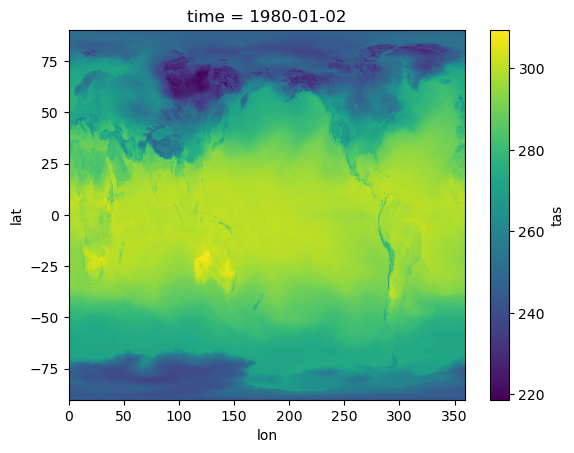

In [7]:
ds_final.isel(time=1).tas.plot()

In [17]:
# Write to azure storage
ds_final = ds_final.chunk({'time':365, 'lat':180, 'lon':360})
    
compressor = zarr.Blosc(cname='zstd', clevel=3)
encoding = {vname: {'compressor': compressor} for vname in ds_final.data_vars}
    
azure_prefix = 'era5/temperature'
store = zarr.ABSStore(client=container_client, prefix=azure_prefix)

# store
ds_final.to_zarr(store=store, encoding=encoding, consolidated=True, mode='w')

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.10/ssl.py", line 1342, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLEOFError: EOF occurred in violation of protocol (_ssl.c:997)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/iostream.py", line 696, in _handle_events
    self._handle_read()
  File "/srv/conda/envs/notebook/lib/python3.10

In [ ]:
%%time
# rechunk for quantile calculations
ds_final = ds_final.chunk({'time':-1, 'lat':50, 'lon':50})

# Get 95th, 99th quantiles
ds_q95 = ds_final.quantile(q=0.95, dim='time').compute()
ds_q99 = ds_final.quantile(q=0.99, dim='time').compute()